**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow.keras. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. Libraries and settings]
2. Analyze data]
3. Manipulate data]
4. Model and validate data]
5. Predictions

**Reference:**  

Adapted from https://www.kaggle.com/code/raoulma/ny-stock-price-prediction-rnn-lstm-gru
Attention, the source is with old syntax.

# 1. Libraries and Settings

In [ ]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.getcwd()+':', os.listdir(os.getcwd()));


c:\Users\asus: ['.AnyLogicPLE', '.arduinoIDE', '.codex', '.docker', '.gitconfig', '.ipython', '.keras', '.matplotlib', '.spss', '.VirtualBox', '.vscode', '20150830 LTP Case Study Example.pdf', '3D Objects', 'alocacao_veiculos_otimizada.csv', 'AppData', 'Application Data', 'Contacts', 'Cookies', 'DATAFRESH.xlsx', 'Definições Locais', 'docker', 'Documents', 'Downloads', 'escalonamento.xlsx', 'Favorites', 'Links', 'Menu Iniciar', 'meu_projeto', 'Microsoft', 'Modelos', 'Models', 'Music', 'NetHood', 'NTUSER.DAT', 'ntuser.dat.LOG1', 'ntuser.dat.LOG2', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TM.blf', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000001.regtrans-ms', 'NTUSER.DAT{2ad838bc-efea-11ee-a54d-000d3a94eaa1}.TMContainer00000000000000000002.regtrans-ms', 'ntuser.ini', 'OneDrive', 'OneDrive - Universidade de Aveiro', 'OneDrive - Universidade do Porto', 'Os Meus Documentos', 'PrintHood', 'Recent', 'Saved Games', 'Searches', 'SendTo', 'Videos']
c:\Use

# 2. Load Data 
- load stock prices from prices-split-adjusted.csv

In [10]:
# import all stock prices 
df = pd.read_csv("prices-split-adjusted.csv/prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()

# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['EQIX', 'ARNC', 'BLK', 'HP', 'VFC', 'EOG', 'EMR', 'PHM', 'VRSK', 'PSX']


# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [12]:
from sklearn.preprocessing import MinMaxScaler

FEATURES = ['open', 'high', 'low', 'close']

def normalize_data(df):
    scaler = MinMaxScaler()
    df[FEATURES] = scaler.fit_transform(df[FEATURES])
    return df

def load_data(stock, seq_len):
    series = stock.values
    windows = np.array([series[i:i+seq_len] for i in range(len(series) - seq_len)])
    valid_len = int(round(valid_set_size_percentage / 100 * len(windows)))
    test_len = int(round(test_set_size_percentage / 100 * len(windows)))
    train_len = len(windows) - valid_len - test_len

    x = windows[:, :-1]
    y = windows[:, -1]

    return (
        x[:train_len], y[:train_len],                                       # treino
        x[train_len:train_len+valid_len], y[train_len:train_len+valid_len], # validação
        x[train_len+valid_len:], y[train_len+valid_len:]                    # teste
    )

df_stock = (
    df.loc[df.symbol == 'EQIX', FEATURES]
      .pipe(normalize_data)
)

seq_len = 20
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock, seq_len)

for name, value in {
    'x_train': x_train.shape,
    'y_train': y_train.shape,
    'x_valid': x_valid.shape,
    'y_valid': y_valid.shape,
    'x_test': x_test.shape,
    'y_test': y_test.shape,
}.items():
    print(f'{name}.shape = {value}')
# 

x_train.shape = (1394, 19, 4)
y_train.shape = (1394, 4)
x_valid.shape = (174, 19, 4)
y_valid.shape = (174, 4)
x_test.shape = (174, 19, 4)
y_test.shape = (174, 4)


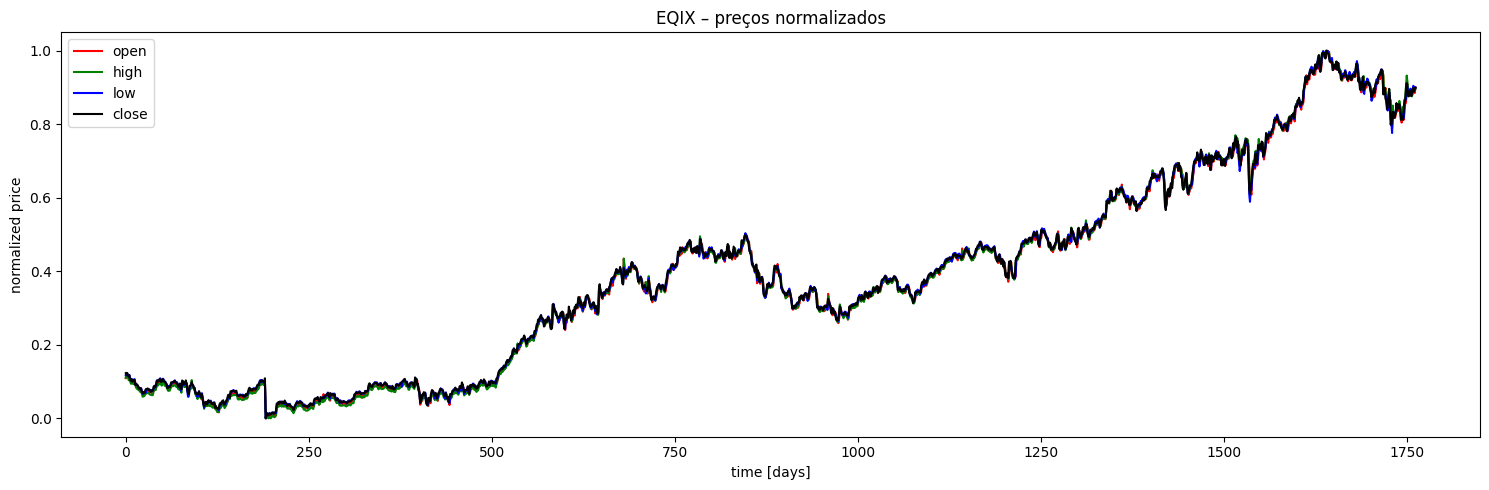

In [15]:
plt.figure(figsize=(15, 5))
for feature, color in zip(FEATURES, ['red', 'green', 'blue', 'black']):
    plt.plot(df_stock[feature].values, color=color, label=feature)

plt.title('EQIX – preços normalizados')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.tight_layout()
plt.show()


# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [19]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense

# --- Data batching utility (opcional) ---
def get_next_batch(x_train, y_train, batch_size):
    idx = np.random.randint(0, x_train.shape[0], batch_size)
    return x_train[idx], y_train[idx]

# --- Hyperparameters ---
n_steps = seq_len - 1   # número de timesteps
n_inputs = 4
n_neurons = 200
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100

# --- Modelo RNN em Keras ---
model = Sequential()

# 🔹 RNN básica (podes trocar por LSTM ou GRU)
for i in range(n_layers - 1):
    model.add(GRU(n_neurons, activation='leaky_relu', return_sequences=True, input_shape=(n_steps, n_inputs)))
model.add(GRU(n_neurons, activation='leaky_relu', return_sequences=True, input_shape=(n_steps, n_inputs)))

# 🔹 Camada densa de saída
model.add(Dense(n_outputs))

# --- Compilação ---
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss='mse')

# --- Treino ---
history = model.fit(
    x_train, y_train,
    epochs=n_epochs,
    batch_size=batch_size,
    validation_data=(x_valid, y_valid),
    verbose=1
)

# --- Previsões ---
y_train_pred = model.predict(x_train)
y_valid_pred = model.predict(x_valid)
y_test_pred  = model.predict(x_test)


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - loss: 0.0964 - val_loss: 0.0118
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 0.0023
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 5.6731e-04 - val_loss: 0.0015
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 4.1305e-04 - val_loss: 0.0011
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 3.4102e-04 - val_loss: 0.0018
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.5711e-04 - val_loss: 0.0015
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.2276e-04 - val_loss: 0.0011
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.1630e-04 - val_loss: 0.0020
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.3195e-04 - val_loss: 9.0660e-04
Epoch 10/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 3.4581e-04 - val_loss: 0.0021
Epoch 11/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 4.5352e-04 - val_loss: 9.9054e-04
Epoch 12

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [20]:
y_train.shape

(1394, 4)

correct sign prediction for close - open price for train/valid/test: 0.59/0.74/0.78


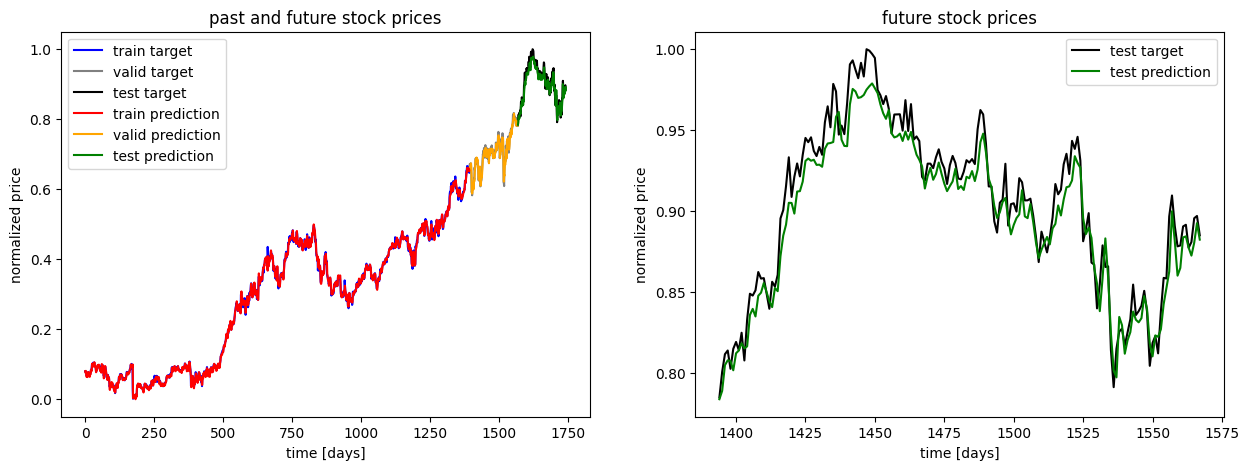

In [22]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
